# 03 : Stock Data Analysis (Specific dataset)

การวิเคราะห์ข้อมูลและการทำนายแนวโน้มราคาหลักทรัพย์รายตัว (หลังขั้นตอนการปรับจูนค่าพารามิเตอร์)

### คำอธิบาย

*   เป็นโปรแกรมที่สร้างวิธีการทำนายแนวโน้มราคาหลักทรัพย์แบบรายวันผ่านเทคนิควิธีการทำเหมืองข้อมูล หลังจากที่ได้ค้นหาและเลือกค่าพารามิเตอร์ **window_size** และ **number_of_pattern** ในขั้นตอนการปรับจูนค่าพารามิเตอร์บนโปรแกรม 02_Stock_Trends_Prediction_(Data_Mining_technique)
*   ค่าพารามิเตอร์ที่ต้องกำหนด คือ ขนาดรูปแบบราคา (w) และ จำนวนรูปแบบราคา (no_of_pattern)
*   ตัวแปรที่ใช้ คือ ราคาปิด (Close) และปริมาณซื้อขายรายวัน (Volume)
*   วิธีการทำนายผล ได้แก่ วิธีการวิเคราะห์ทางสถิติ (Statistical Analysis) วิธีจำแนกแบบเบย์อย่างง่าย (Naive Bayes Classifier) และวิธีจำแนกต้นไม้การตัดสินใจ (Decision Tree Classifier)
*   เป็นโปรแกรมที่ใช้วิเคราะห์ผลจากการทำนายแนวโน้มราคาแบบรายวัน

### ขั้นตอนการศึกษา

*   1) กำหนดชุดข้อมูลและค่าพารามิเตอร์ที่ดีที่สุดจากเทคนิควิธีการทำเหมืองข้อมูล
*   2) ทำเหมืองข้อมูลบนชุดข้อมูลเพื่อค้นหารูปแบบราคาและทำการแสดงผลการค้นหารูปแบบราคาทั้งหมด
*   3) เทรนโมเดลและรันผลการทำนายบนชุดข้อมูลทดสอบ
*   4) วิเคราะห์ผลการทำนายแนวโน้มแบบรายวัน
*   5) เปรียบเทียบประสิทธิภาพการทำนายผล




# 1) Data Collection

1.1) ทำการติดตั้ง Library ที่จำเป็นทั้งหมดในการใช้งาน

In [1]:
# ignore all warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Stock Data Collection Library
# Import from yahoo financial 

!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Import similarity distance computation algorithm  
# Dynamic Time Warping (DTW) algorithm  

!pip install dtaidistance
from dtaidistance import dtw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Libraries for processing and mining stock data.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Libraries for modeling stock data.

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [6]:
# Libraries for evaluation metrics.

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

1.2) กำหนดชุดข้อมูลและค่าที่เกี่ยวข้องที่ต้องการใช้ศึกษา



*   1) **stock_price** : ชื่อหลักทรัพย์ (ตัวย่อภาษาอังกฤษ) 
*   2) **start_date** : วันที่เริ่มต้นขอชุดข้อมูล (YYYY-MM-DD)
*   3) **end_date** : วันที่สิ้นสุดของชุดข้อมูล (YYYY-MM-DD)
*   4) **interval** : ช่วงกรอบเวลา (Timeframe) หน่วย d เท่ากับ วัน 
*   5) **no_of_pattern** : จำนวนรูปแบบ (Patterns) ที่ต้องการใช้เป็นตัวแปร
*   6) **w** : ขนาดรูปแบบ (Window size) ที่ต้องการใช้เป็นตัวแปร

In [7]:
# Setting parameters for modeling and evaluating.

# Stock data  
stock_price = 'KBANK.BK'   

# Start Date  
start_date = '2017-11-10'   

# End Date
end_date = '2022-11-11'

# Timeframe of Stock data 
interval = '1d'         

# Number of Pattern : NO_OF_PATTERN
no_of_pattern = 15

# Length of Pattern (Window size) : W 
w = 6

1.3) ดึงชุดข้อมูล

In [8]:
# Import stock data from SET (Thailand)

df = yf.download(tickers=stock_price, start=start_date, end=end_date, interval=interval)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-10,218.0,220.0,217.0,217.0,190.248154,3365200
2017-11-13,216.0,219.0,215.0,217.0,190.248154,3414400
2017-11-14,218.0,224.0,217.0,224.0,196.385178,4853400
2017-11-15,223.0,223.0,220.0,220.0,192.878311,3879500
2017-11-16,220.0,223.0,220.0,221.0,193.755020,3443400
...,...,...,...,...,...,...
2022-11-04,149.0,149.5,148.0,148.5,148.500000,12164700
2022-11-07,149.0,149.5,148.0,148.0,148.000000,5119300
2022-11-08,149.0,149.5,148.0,148.5,148.500000,5572100


1.4) สำรวจชุดข้อมูลในเบื้องต้น

In [9]:
# Check data information 

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1214 entries, 2017-11-10 to 2022-11-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1214 non-null   float64
 1   High       1214 non-null   float64
 2   Low        1214 non-null   float64
 3   Close      1214 non-null   float64
 4   Adj Close  1214 non-null   float64
 5   Volume     1214 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 66.4 KB


In [10]:
# drop all null value in stock data (if) 

df = df.dropna()

In [11]:
# Check "close price" column in our dataset (target feature) 

df['Close']

Date
2017-11-10    217.0
2017-11-13    217.0
2017-11-14    224.0
2017-11-15    220.0
2017-11-16    221.0
              ...  
2022-11-04    148.5
2022-11-07    148.0
2022-11-08    148.5
2022-11-09    147.5
2022-11-10    148.0
Name: Close, Length: 1214, dtype: float64

1.5) พล็อตกราฟเพื่อดูกราฟการเคลื่อนที่ของราคาปิดย้อนหลังจนถึงช่วงเวลาปัจจุบันที่ได้ทำการจัดเก็บ

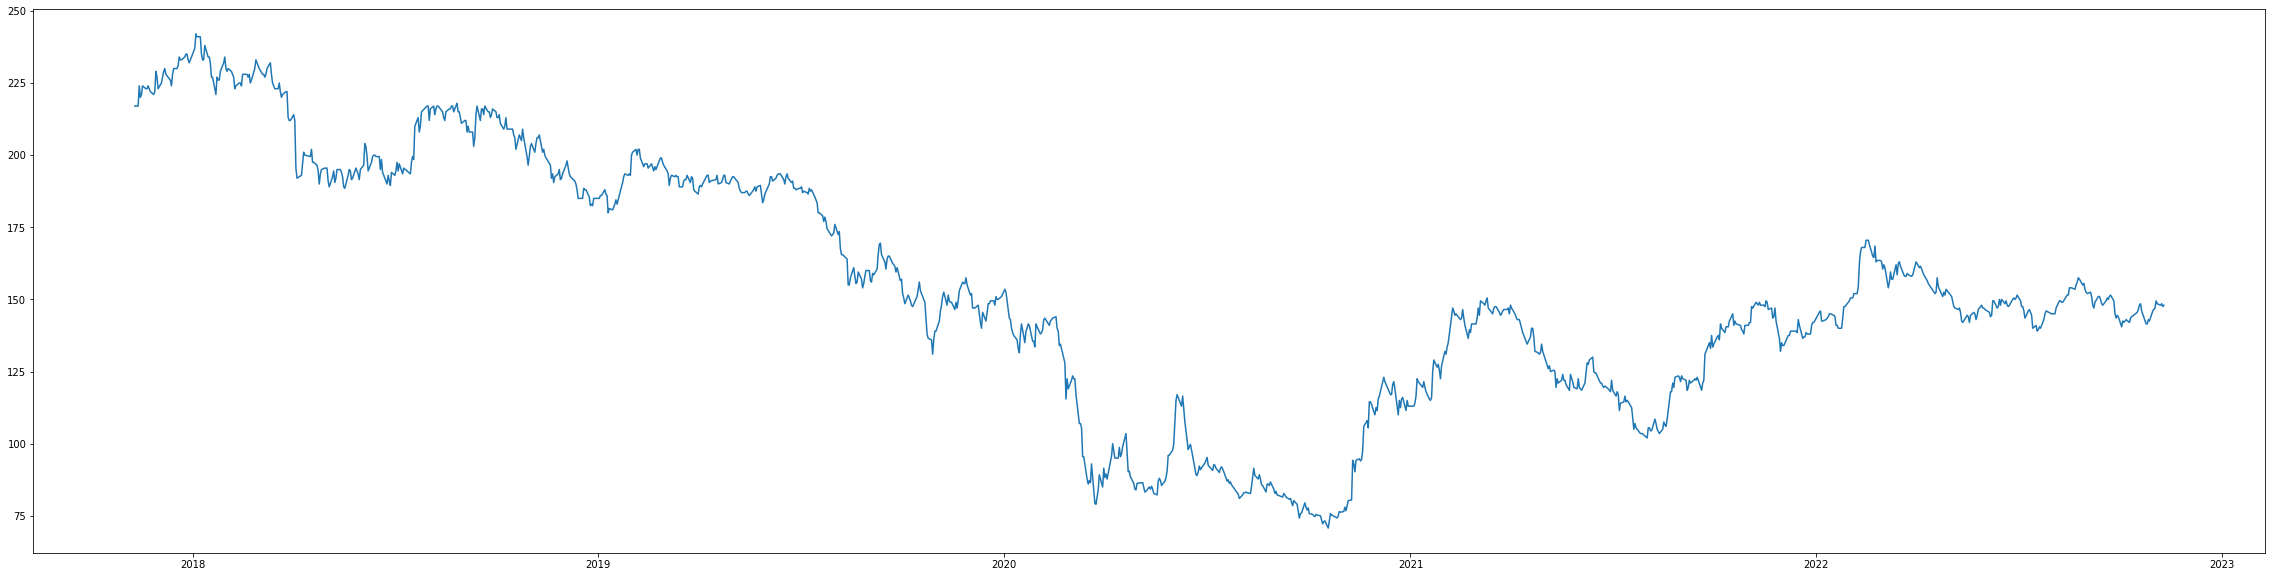

In [12]:
# Plotting stock close price (Line plot) from inital to current date.
# Let's see the volatility of stock market price data.

plt.figure(figsize=(40,10))
plt.plot(df['Close'])

# 2) Data Preprocessing

2.1) สร้างชุดข้อมูลเพื่อจัดเก็บเฉพาะข้อมูลราคาปิด (Close) ซึ่งเป็นตัวแปรที่เราจะใช้ในการศึกษานี้

In [13]:
# Generate a new dataframe that contain only a 'Date' and 'Close price' column.

df_closed_price = df['Close']
df_closed_price = pd.DataFrame(df_closed_price)
df_closed_price.rename(columns = {'Close':'Close price'}, inplace = True)
df_closed_price

,Close price
Date,
2017-11-10,217.0
2017-11-13,217.0
2017-11-14,224.0
2017-11-15,220.0
2017-11-16,221.0
...,...
2022-11-04,148.5
2022-11-07,148.0
2022-11-08,148.5


2.2) สำรวจชุดข้อมูลในเบื้องต้น

In [14]:
# check data information

df_closed_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1214 entries, 2017-11-10 to 2022-11-10
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close price  1214 non-null   float64
dtypes: float64(1)
memory usage: 19.0 KB


In [15]:
# reset index in dataset 

df_closed_price.reset_index(inplace=True)
df_closed_price

,Date,Close price
0,2017-11-10,217.0
1,2017-11-13,217.0
2,2017-11-14,224.0
3,2017-11-15,220.0
4,2017-11-16,221.0
...,...,...
1209,2022-11-04,148.5
1210,2022-11-07,148.0
1211,2022-11-08,148.5
1212,2022-11-09,147.5


In [16]:
# show the dataset that contain "Current Pattern" in "w" days
# w = Window size 

df_closed_price.tail(w)

,Date,Close price
1208,2022-11-03,149.5
1209,2022-11-04,148.5
1210,2022-11-07,148.0
1211,2022-11-08,148.5
1212,2022-11-09,147.5
1213,2022-11-10,148.0


2.3) ปรับขนาดชุดข้อมูล (Data Normalization)

In [17]:
# Using MinMaxScaler function to transform data into scale [0,1].
# Scaling a 'Closr price' column in close price dataset.

scaler = MinMaxScaler()
df_closed_price_scaled = scaler.fit_transform(df_closed_price[['Close price']])

In [18]:
# Add a 'Close price scaled' column to dataset.

df_closed_price['Close price (scaled)'] = df_closed_price_scaled
df_closed_price

,Date,Close price,Close price (scaled)
0,2017-11-10,217.0,0.854015
1,2017-11-13,217.0,0.854015
2,2017-11-14,224.0,0.894891
3,2017-11-15,220.0,0.871533
4,2017-11-16,221.0,0.877372
...,...,...,...
1209,2022-11-04,148.5,0.454015
1210,2022-11-07,148.0,0.451095
1211,2022-11-08,148.5,0.454015
1212,2022-11-09,147.5,0.448175


2.4) พล็อตกราฟราคาปิดของชุดข้อมูล (หลังจากที่ได้ปรับสเกลข้อมูล)

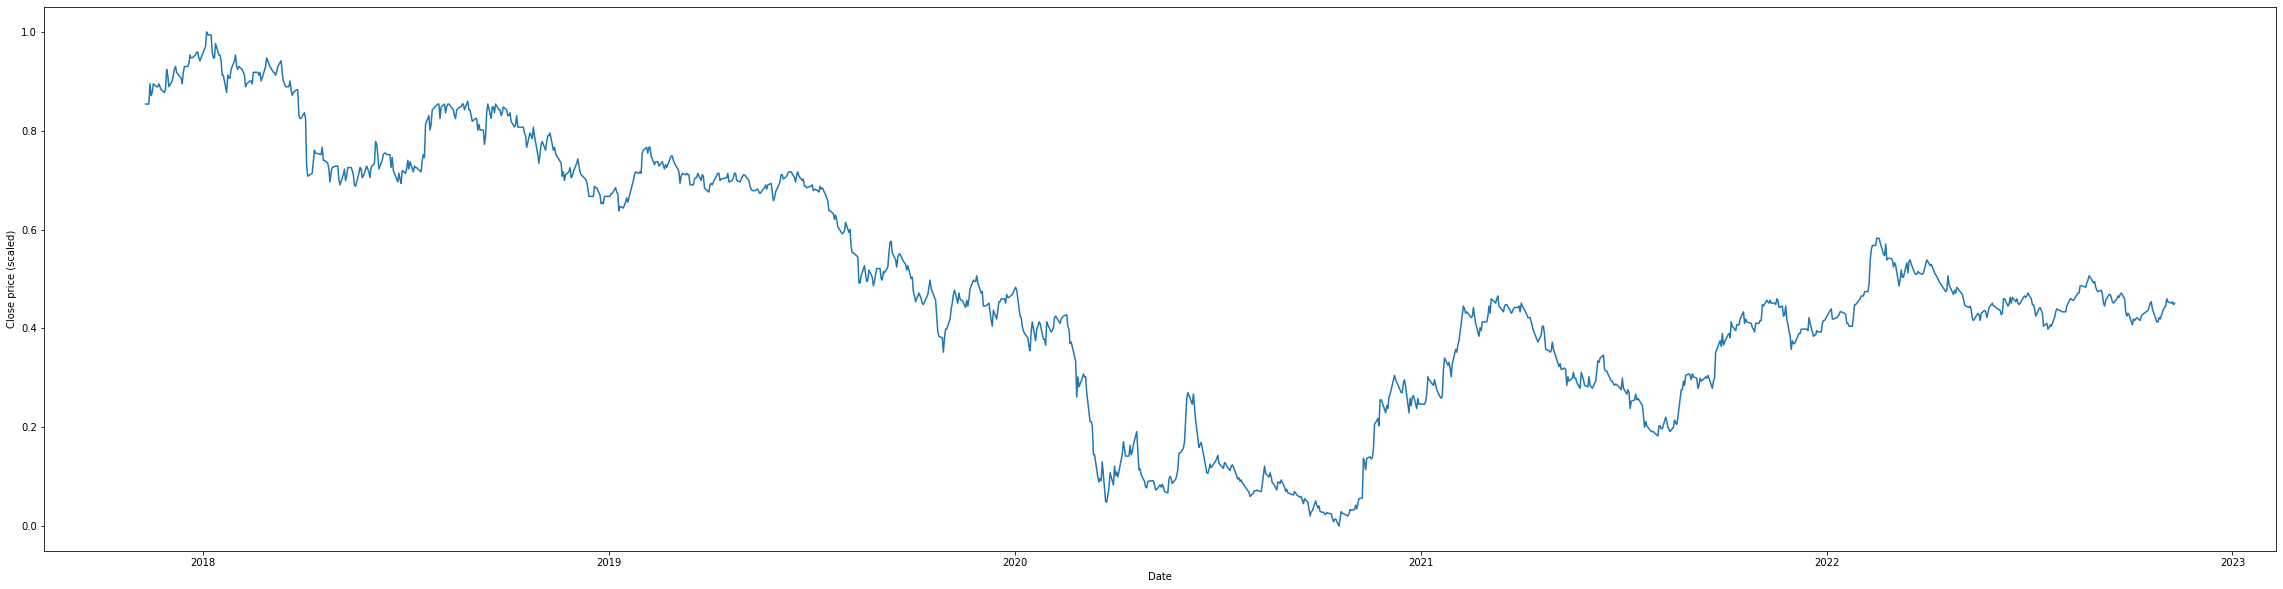

In [19]:
# Plotting "Close price" stock data after scaling.
# Now. the scale of close price are between 0 and 1.

plt.figure(figsize=(40,10))
sns.lineplot(x=df_closed_price['Date'], y=df_closed_price['Close price (scaled)'])
# sns.set_style('darkgrid')

# 3) Data Mining

3.1) กำหนดรูปแบบราคาปัจจุบัน (Current Pattern)

In [20]:
print('Window size =',w)

Window size = 6


In [21]:
df_closed_price['Close price (scaled)']

0       0.854015
1       0.854015
2       0.894891
3       0.871533
4       0.877372
          ...   
1209    0.454015
1210    0.451095
1211    0.454015
1212    0.448175
1213    0.451095
Name: Close price (scaled), Length: 1214, dtype: float64

เราจะได้รูปแบบปัจจุบันที่มีขนาด size = w

In [22]:
length = df_closed_price.shape[0]
df_current = df_closed_price.iloc[length-w:length,[0,1,2]]
df_current

,Date,Close price,Close price (scaled)
1208,2022-11-03,149.5,0.459854
1209,2022-11-04,148.5,0.454015
1210,2022-11-07,148.0,0.451095
1211,2022-11-08,148.5,0.454015
1212,2022-11-09,147.5,0.448175
1213,2022-11-10,148.0,0.451095


3.2) พล็อตกราฟของรูปแบบราคาปัจจุบัน

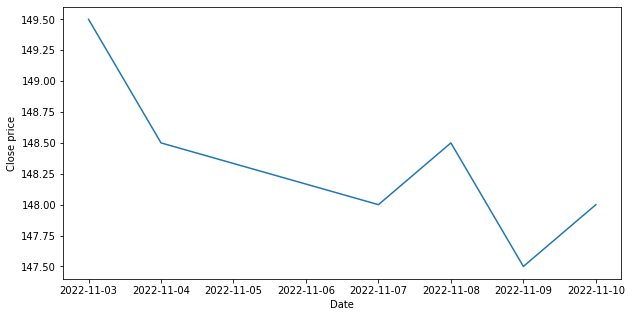

In [23]:
plt.figure(figsize=(10,5))
sns.lineplot(x=df_current['Date'], y=df_current['Close price'])

นำข้อมูลราคาปิดของรูปแบบราคาปัจจุบันมาเก็บเป็นลิสต์ (List) เพื่อใช้ในการคำนวน

In [24]:
df_current_list = list(df_current['Close price'])
df_current_list

[149.5, 148.5, 148.0, 148.5, 147.5, 148.0]

ถัดมา ทำการปรับขนาดข้อมูลของรูปแบบราคาปัจจุบัน

In [25]:
price_max = max(df_current_list)
price_min = min(df_current_list)

df_current_scaled = []

for x in df_current_list :
  df_current_scaled.append( (x - price_min) / (price_max - price_min) )

In [26]:
df_current_scaled

[1.0, 0.5, 0.25, 0.5, 0.0, 0.25]

พล็อตกราฟของรูปแบบราคาปัจจุบันหลังจากที่ได้ปรับขนาดข้อมูล

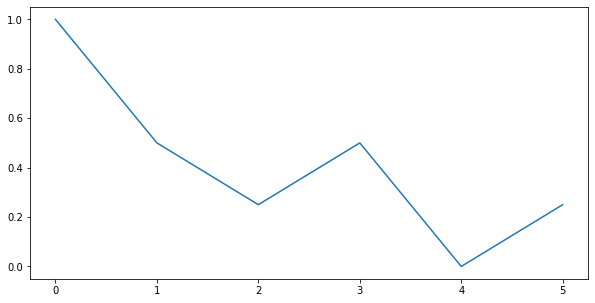

In [27]:
plt.figure(figsize=(10,5))
plt.plot(df_current_scaled)

3.3) กำหนดชุดข้อมูลย้อนหลังในอดีตทั้งหมด (Historical Data) โดยแยกออกจากข้อมูลรูปแบบราคาปัจจุบัน 

In [28]:
df_historical = df_closed_price.iloc[:df_closed_price.shape[0]-w,[0,1,2]]
df_historical

,Date,Close price,Close price (scaled)
0,2017-11-10,217.0,0.854015
1,2017-11-13,217.0,0.854015
2,2017-11-14,224.0,0.894891
3,2017-11-15,220.0,0.871533
4,2017-11-16,221.0,0.877372
...,...,...,...
1203,2022-10-27,143.0,0.421898
1204,2022-10-28,142.5,0.418978
1205,2022-10-31,146.0,0.439416
1206,2022-11-01,146.5,0.442336


In [29]:
df_closed_price['Close price (scaled)']

0       0.854015
1       0.854015
2       0.894891
3       0.871533
4       0.877372
          ...   
1209    0.454015
1210    0.451095
1211    0.454015
1212    0.448175
1213    0.451095
Name: Close price (scaled), Length: 1214, dtype: float64

ตรวจสอบขนาดของชุดข้อมูลย้อนหลังในอดีต (Historical data) หลังจากแยกข้อมูลรูปแบบราคาปัจจุบันออก

In [30]:
print('Size of Historical data =',length-w)

Size of Historical data = 1208


3.4) พล็อตกราฟราคาหลักทรัพย์ย้อนหลัง พร้อมกับ พล็อตกราฟรูปแบบราคาปัจจุบัน เพื่อใช้เป็นรูปแบบในการค้นหาในชุดข้อมูลในอดีต

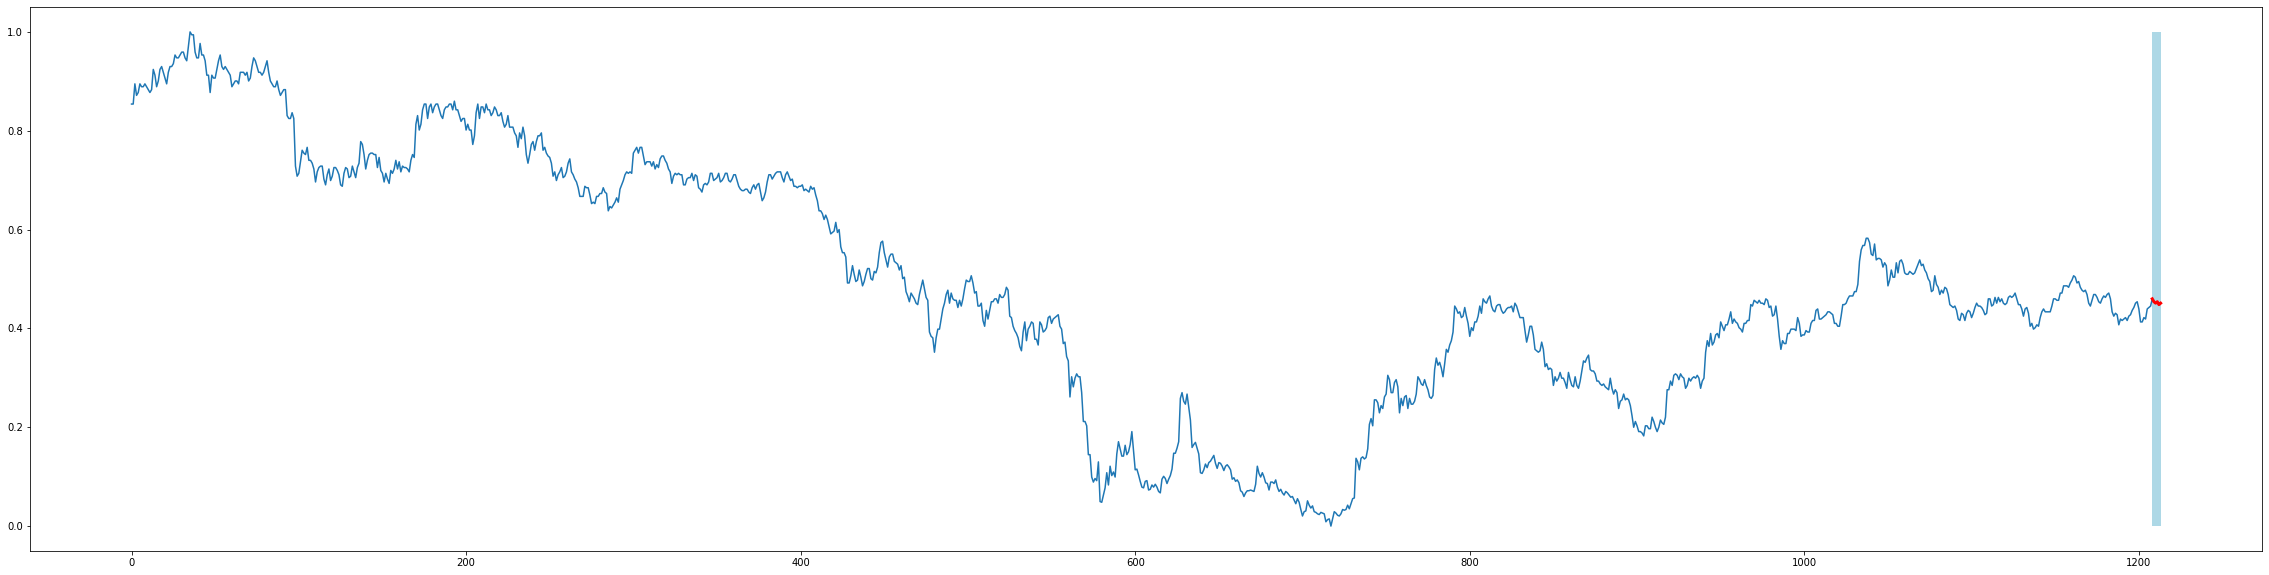

In [31]:
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(40,10))
ax = fig.add_subplot(1, 1, 1)

ax.plot(df_closed_price['Close price (scaled)'])

ax.plot(df_closed_price.iloc[length-w:length,2:],c='red',linewidth=3)
rect = Rectangle((length-w, 0), w-1, 1, facecolor='lightblue')
ax.add_patch(rect)

3.5) ทำ sliding window บนชุดข้อมูลย้อนหลังในอดีต เพื่อจัดเก็บรูปแบบราคาในอดีตทั้งหมด

In [32]:
df_historical

,Date,Close price,Close price (scaled)
0,2017-11-10,217.0,0.854015
1,2017-11-13,217.0,0.854015
2,2017-11-14,224.0,0.894891
3,2017-11-15,220.0,0.871533
4,2017-11-16,221.0,0.877372
...,...,...,...
1203,2022-10-27,143.0,0.421898
1204,2022-10-28,142.5,0.418978
1205,2022-10-31,146.0,0.439416
1206,2022-11-01,146.5,0.442336


In [33]:
print('Length of Historical data =',len(df_historical))

Length of Historical data = 1208


Sliding window algorithm

In [34]:
list_of_subsequence_original = []
def sliding_window(elements, window_size):
    for i in range(len(elements)):
        list_of_subsequence_original.append(elements[i:i+window_size])

In [35]:
sliding_window(list(df_historical['Close price']), w)

**NOTE :** เนื่องจากในขั้นตอนการทำ Sliding window นั้น เราจะไม่สามารถทำการตัดช่วงของข้อมูลได้ตั้งแต่ subsequence ที่ช่วง length-w ได้ ดังนั้นจึงต้องตัดช่วงนี้ทิ้ง

ตรวจเช็คลำดับย่อยทั้งหมดในชุดข้อมูลในอดีต จะเห็นได้ว่าช่วงที่ length-w เป็นต้นไปจนถึงช่วงข้อมูลล่าสุด มีค่า Null จัดเก็บอยู่

In [36]:
# Historical subsequences before cleaning.

df_list = pd.DataFrame(list_of_subsequence_original)
df_list.tail(15)

,0,1,2,3,4,5
1193,142.0,143.5,144.0,145.5,146.5,148.0
1194,143.5,144.0,145.5,146.5,148.0,148.5
1195,144.0,145.5,146.5,148.0,148.5,146.0
1196,145.5,146.5,148.0,148.5,146.0,141.5
1197,146.5,148.0,148.5,146.0,141.5,141.5
1198,148.0,148.5,146.0,141.5,141.5,143.0
1199,148.5,146.0,141.5,141.5,143.0,142.5
1200,146.0,141.5,141.5,143.0,142.5,146.0
1201,141.5,141.5,143.0,142.5,146.0,146.5
1202,141.5,143.0,142.5,146.0,146.5,147.0


In [37]:
# List of subsequence (Patterns) which will be used for calculation in Modeling process.
 
list_of_subsequence_original_for_calculation = list_of_subsequence_original.copy()
list_of_subsequence_original_for_calculation.append([df_current_list[0]])

ถัดมา ลบแถวของข้อมูลที่มีค่า Null ออก

In [38]:
# Delete all null value in dataset.

del list_of_subsequence_original[-(w-1):]

In [39]:
# Historical subsequences after cleaning.

df_list = pd.DataFrame(list_of_subsequence_original)
df_list.tail(15)

,0,1,2,3,4,5
1188,140.5,142.5,142.0,142.5,143.0,142.0
1189,142.5,142.0,142.5,143.0,142.0,143.5
1190,142.0,142.5,143.0,142.0,143.5,144.0
1191,142.5,143.0,142.0,143.5,144.0,145.5
1192,143.0,142.0,143.5,144.0,145.5,146.5
1193,142.0,143.5,144.0,145.5,146.5,148.0
1194,143.5,144.0,145.5,146.5,148.0,148.5
1195,144.0,145.5,146.5,148.0,148.5,146.0
1196,145.5,146.5,148.0,148.5,146.0,141.5
1197,146.5,148.0,148.5,146.0,141.5,141.5


ถัดมา ทำการปรับขนาดข้อมูลให้เป็นบรรทัดฐานในแต่ละลำดับย่อย (Subsequences) ทั้งหมด ในลักษณะแบบเดียวกับรูปแบบราคาปัจจุบัน (Current Pattern) 

In [40]:
# Normalize all subsequences in the list.
# Same as Current pattern did.

list_of_subsequence_scaled = []

for i in range(len(list_of_subsequence_original)) :  
  price_max = max(list_of_subsequence_original[i])
  price_min = min(list_of_subsequence_original[i])      
  
  temp_list_scaled = []
  
  for x in list_of_subsequence_original[i] :
    try :
      temp_list_scaled.append( (x - price_min) / (price_max - price_min) )
    except ZeroDivisionError :
        temp_list_scaled.append(0)
  
  list_of_subsequence_scaled.append(temp_list_scaled)

In [41]:
list_of_subsequence = list_of_subsequence_scaled

3.6) วิธีการค้นพบโมทีฟ (Motif Discovery)

วิธีการค้นพบโมทีฟเป็นวิธีการค้นหาคู่ลำดับย่อยที่มีลักษณะคล้ายคลึงกันมากที่สุดในข้อมูลอนุกรมเวลา ซึ่งจะนำมาใช้ในการค้นหารูปแบบราคาในอดีตที่คล้ายกันบนชุดข้อมูลราคาหลักทรัพย์ ผ่านเทคนิควิธีการวัดระยะห่างความคล้ายคลึงกัน (Similarity Distance Measure) โดยจะใช้อัลกอริทึม Dynamic Time Warping ในการวัดระยะห่าง

Ex. ตัวอย่างการวัดระยะห่างความคล้ายคลึงกันระหว่าง 2 คู่ลำดับ ด้วยอัลกอริทึมไดนามิกไทม์วาร์ปปิง (Dynamic Time Warping : DTW)

In [96]:
# Example of two subsequences similarity measure.

s1 = [0, 0, 1, 2, 1, 0, 1, 0, 0]
s2 = [0, 1, 2, 0, 0, 0, 0, 0, 0]

distance = dtw.distance(s1, s2)
print('Similarity distance value between s1 and s2 =',distance)

Similarity distance value between s1 and s2 = 1.4142135623730951


โดยเริ่มต้น ทำการคำนวนหารูปแบบราคาที่คล้ายคลึงกับรูปแบบราคาปัจจุบันมากที่สุดในชุดข้อมูลในอดีต

In [43]:
# Current pattern list (raw data).

df_current_list

[149.5, 148.5, 148.0, 148.5, 147.5, 148.0]

In [44]:
# Current pattern list (scaled).

df_current_scaled

[1.0, 0.5, 0.25, 0.5, 0.0, 0.25]

In [45]:
# Historical patterns list with index (For similarity searching process).

list_of_subsequence_scaled_with_index_1 = []
i = 0
for sub in list_of_subsequence_scaled :
  list_of_subsequence_scaled_with_index_1.append([i,sub])
  i = i + 1

ขั้นตอนสำหรับการวัดระยะห่างความคล้ายคลึงกันระหว่างรูปแบบราคาปัจจุบันกับรูปแบบราคาในอดีตทั้งหมด (Similarity Distance Measure)

In [46]:
# Similarity Search in Historical patterns.
# The algorithm is used for measuring the similarity between Current pattern and Historical patterns in the list.

list_of_subsequence_scaled_with_index = list_of_subsequence_scaled_with_index_1.copy()

x = df_current_scaled

index_list = []
min_distance_list = []
sub_list = []

for i in range(no_of_pattern) :

  list_of_distance_value = []

  for j in range(len(list_of_subsequence_scaled_with_index)) :
    y = list_of_subsequence_scaled_with_index[j][1]
    distance = dtw.distance(x, y)
    list_of_distance_value.append(distance)
  
  min_value = min(list_of_distance_value)
  print(min_value,':',list_of_subsequence_scaled_with_index[list_of_distance_value.index(min_value)][0],':',list_of_subsequence_scaled_with_index[list_of_distance_value.index(min_value)][1])

  index_list.append(list_of_subsequence_scaled_with_index[list_of_distance_value.index(min_value)][0])
  sub_list.append(list_of_subsequence_scaled_with_index[list_of_distance_value.index(min_value)][1])
  min_distance_list.append(min_value)

  del list_of_subsequence_scaled_with_index[list_of_distance_value.index(min_value)-w : list_of_distance_value.index(min_value)+w]

0.1901500060304717 : 455 : [1.0, 0.5454545454545454, 0.45454545454545453, 0.36363636363636365, 0.0, 0.2727272727272727]
0.20889962483077337 : 410 : [1.0, 0.46153846153846156, 0.46153846153846156, 0.3076923076923077, 0.0, 0.23076923076923078]
0.2246185983823001 : 984 : [1.0, 0.42857142857142855, 0.0, 0.2857142857142857, 0.19047619047619047, 0.19047619047619047]
0.2287698409721183 : 830 : [1.0, 1.0, 1.0, 0.47058823529411764, 0.0, 0.29411764705882354]
0.24739123295971652 : 148 : [1.0, 0.47058823529411764, 0.35294117647058826, 0.0, 0.35294117647058826, 0.11764705882352941]
0.25 : 194 : [1.0, 1.0, 0.5, 0.0, 0.25, 0.25]
0.25 : 876 : [1.0, 1.0, 0.5, 0.25, 0.5, 0.0]
0.2514749390504235 : 1078 : [1.0, 0.5384615384615384, 0.38461538461538464, 0.0, 0.23076923076923078, 0.07692307692307693]
0.25609845714702467 : 476 : [1.0, 0.3888888888888889, 0.3055555555555556, 0.2777777777777778, 0.0, 0.2777777777777778]
0.27189445157594505 : 662 : [1.0, 0.42105263157894735, 0.3157894736842105, 0.0, 0.2631578947

3.7) พล็อตกราฟรูปแบบราคาที่คล้ายคลึงกันในอดีตทั้งหมด เทียบกับรูปแบบราคาในปัจจุบัน

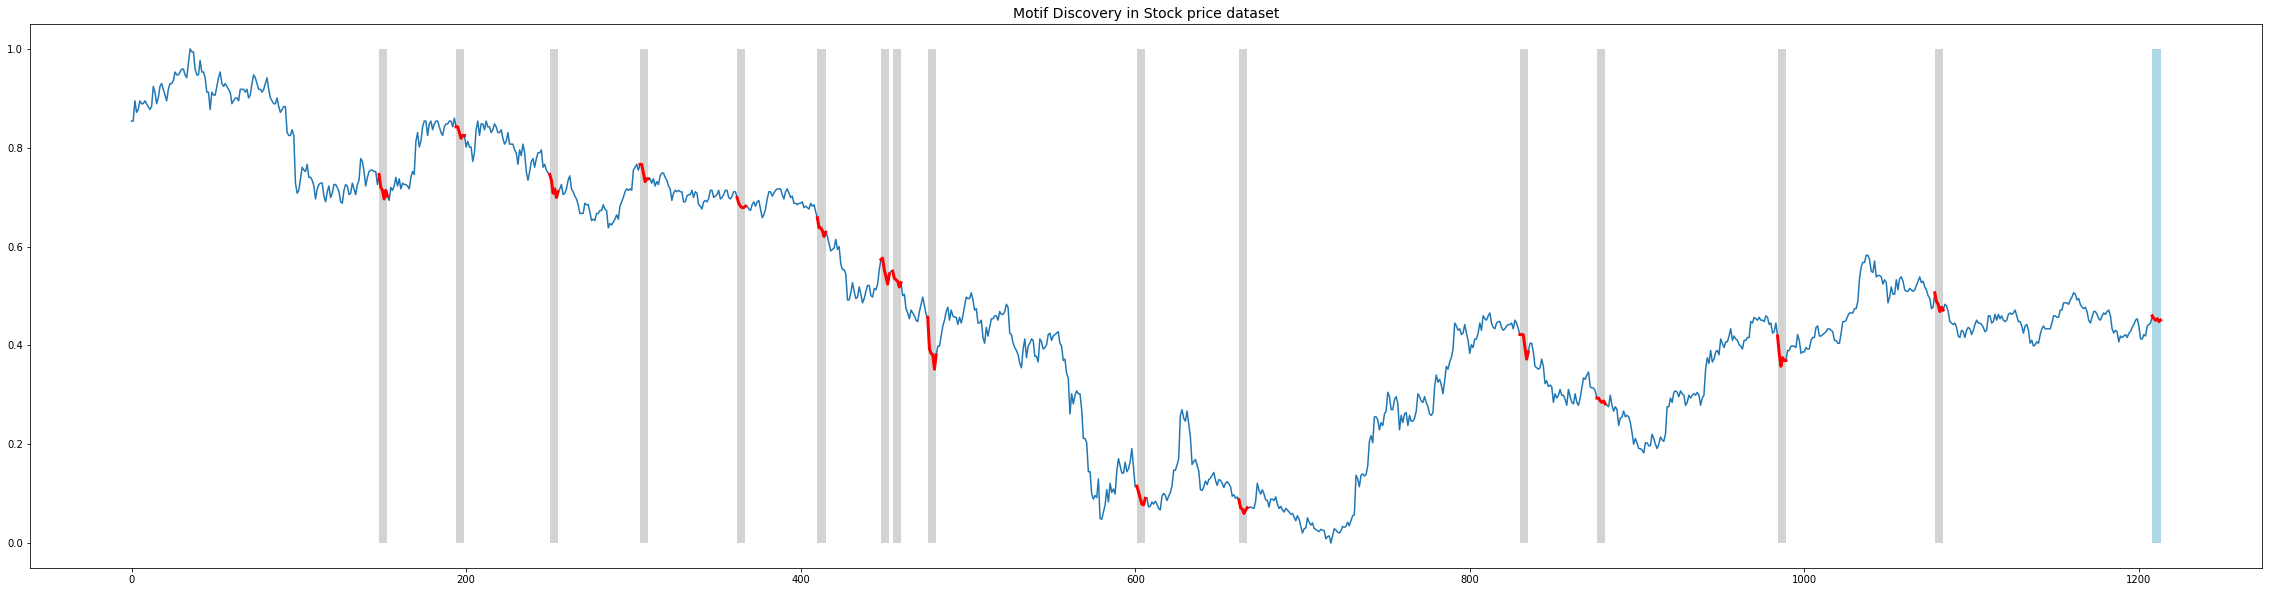

In [47]:
# Plotting the information atfer similarity searching.

fig = plt.figure(figsize=(40,10))
ax = fig.add_subplot(1, 1, 1)

plt.title('Motif Discovery in Stock price dataset', fontsize='14')

# Closed time plotting
ax.plot(df_closed_price['Close price (scaled)'])

# Current pattern.
ax.plot(df_closed_price.iloc[length-w:length,2:],c='red',linewidth=3)
rect = Rectangle((length-w, 0), w-1, 1, facecolor='lightblue')
ax.add_patch(rect)

# All Similar patterns.
for index in index_list :
  ax.plot(df_closed_price.iloc[index:index+w,2:],c='red',linewidth=3)
  rect = Rectangle((index, 0), w-1, 1, facecolor='lightgrey')
  ax.add_patch(rect)

รูปแบบราคาในปัจจุบัน (Current pattern)

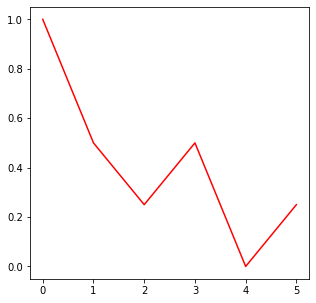

In [48]:
# Current pattern.

plt.figure(figsize=(5,5))
plt.plot(df_current_scaled,c='red')

รูปแบบราคาในอดีตทั้งหมด (Similar patterns)

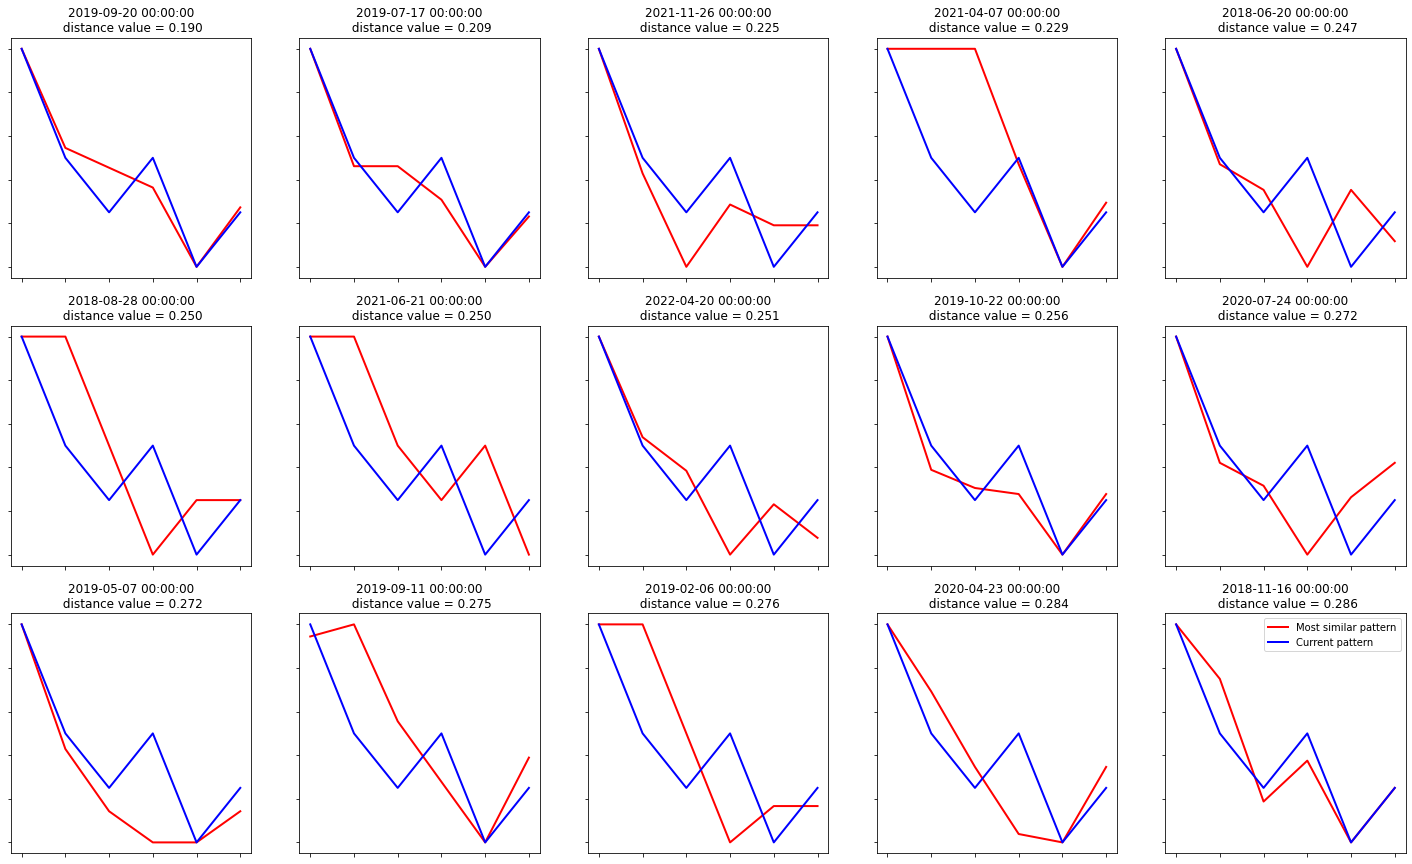

In [49]:
# Plotting Current pattern and All similar patterns.

round_train = 0
index = 0
columns = 5
rows = 3

fig, ax_array = plt.subplots(rows, columns, figsize=(25, 15))
for i,ax_row in enumerate(ax_array):
    for j,axes in enumerate(ax_row):
        axes.plot(sub_list[index],c='r',linewidth ='2',label='Most similar pattern')
        axes.plot(df_current_scaled,c='b',linewidth ='2',label='Current pattern')
        round_train += 1
        axes.set_title('{}\n distance value = {:.3f}'.format(df_historical.iloc[index_list[index],0],min_distance_list[index]))
        axes.set_yticklabels([])
        axes.set_xticklabels([])
        index += 1
        
plt.legend()
plt.show()

ขั้นตอนถัดมา สร้างชุดข้อมูลสำหรับจัดเก็บปริมาณซื้อขาย (Volume) ในแต่ละรูปแบบราคาในอดีตที่ทำการค้นหามา

In [50]:
# Create list for volume in each similar patterns.

df_volume_list = []
for i in index_list :
  df_volume_list.append(list(df.iloc[i:i+w,-1]))

In [51]:
# Dataset for all similar patterns and it volume.
df2 = pd.DataFrame(df_volume_list)
df2

,0,1,2,3,4,5
0,11808000,4578500,6574000,6229400,8258700,6585800
1,6457300,13115100,11335800,8070500,12349700,4556700
2,44001300,62555900,120359500,47261500,29663000,12797200
3,12075900,11431800,6526800,18151500,33938200,20513200
4,9266600,7521600,11163800,6104000,6096300,7953700
5,3397300,5155900,3921700,8632800,2383300,2840800
6,19662500,20940300,12556300,31362400,18315000,18598300
7,24706100,29054600,17700500,20727800,13895500,16013300
8,5356700,32903200,21582200,10427700,21510100,26934300
9,9490600,26130500,13854300,28828600,18877700,13091500


กำหนดข้อมูลปริมาณซื้อขาย (Volume) ของรูปแบบราคาปัจจุบัน

In [52]:
# Current pattern with volume.

df_current_volume = df.iloc[-w:,-1]
df_current_volume

Date
2022-11-03    14693000
2022-11-04    12164700
2022-11-07     5119300
2022-11-08     5572100
2022-11-09     9537100
2022-11-10    10168200
Name: Volume, dtype: int64

# 4) Predictive Modeling

ขั้นตอนสำหรับในการสร้างวิธีการทำนายแนวโน้ม ซึ่งศึกษาทั้งหมด 3 วิธี ประกอบด้วย
*   1) วิธีการวิเคราะห์ทางสถิติ (Statistcal Analysis)
*   2) วิธีจำแนกแบบเบย์อย่างง่าย (Naive Bayes Classifier)
*   3) วิธีจำแนกต้นไม้การตัดสินใจ (Decision Tree Classifier)



## 4.1) Statistical Analysis

### 4.1.1) Probability of Stock Price Movement

หาค่าความความน่าจะเป็นในเบื้องต้นของแนวโน้มราคาในวันถัดไป

เริ่มต้น เช็คจากการเปลี่ยนแปลงของราคาปิดในวันถัดไปในแต่รูปแบบหรือลำดับย่อยทั้งหมดที่ได้มาจากขั้นตอนก่อนหน้า

In [53]:
# Price Movement in the next day for each similar patterns.

index_list
for i in index_list :
  print('[ index of Pattern :',i,']','=','[',list_of_subsequence_original_for_calculation[i][w-1],'->',list_of_subsequence_original_for_calculation[i+w][0],']')

[ index of Pattern : 455 ] = [ 161.0 -> 156.5 ]
[ index of Pattern : 410 ] = [ 178.5 -> 177.0 ]
[ index of Pattern : 984 ] = [ 134.0 -> 137.5 ]
[ index of Pattern : 830 ] = [ 137.0 -> 140.0 ]
[ index of Pattern : 148 ] = [ 191.0 -> 189.5 ]
[ index of Pattern : 194 ] = [ 212.0 -> 208.0 ]
[ index of Pattern : 876 ] = [ 119.0 -> 118.5 ]
[ index of Pattern : 1078 ] = [ 151.5 -> 153.5 ]
[ index of Pattern : 476 ] = [ 136.0 -> 139.0 ]
[ index of Pattern : 662 ] = [ 83.0 -> 83.0 ]
[ index of Pattern : 362 ] = [ 187.5 -> 187.5 ]
[ index of Pattern : 448 ] = [ 164.0 -> 165.0 ]
[ index of Pattern : 304 ] = [ 197.0 -> 197.0 ]
[ index of Pattern : 601 ] = [ 86.25 -> 86.5 ]
[ index of Pattern : 250 ] = [ 192.5 -> 193.5 ]


กำหนดคลาสแนวโน้ม (Uptrend or Downtrend) ในแต่ละลำดับย่อยหรือรูปแบบราคาทั้งหมด

In [54]:
# Labeling for each target class in similar patterns. 
# Class 'Up' if next day price is equal or higher than current price.   
# Class 'Down' if next day price is lower than current price. 

list_of_Price_Movement = []   

all_movement = 0
Trend_up = 0
Trend_down = 0

total_up_price = 0
total_down_price = 0

for i in index_list :

  all_movement = all_movement + 1

  a = list_of_subsequence_original_for_calculation[i][w-1]
  b = list_of_subsequence_original_for_calculation[i+w][0]
  
  if a > b :
    print('[ index :',i,'] : Price Movement = DOWN',' ( -',a-b,')') 
    Trend_down = Trend_down + 1
    total_down_price = total_down_price + (b-a)
    list_of_Price_Movement.append(-1)
  elif a <= b :
    print('[ index :',i,'] : Price Movement = UP',' ( +',b-a,')')
    Trend_up = Trend_up + 1
    total_up_price = total_up_price + (b-a)
    list_of_Price_Movement.append(1)

[ index : 455 ] : Price Movement = DOWN  ( - 4.5 )
[ index : 410 ] : Price Movement = DOWN  ( - 1.5 )
[ index : 984 ] : Price Movement = UP  ( + 3.5 )
[ index : 830 ] : Price Movement = UP  ( + 3.0 )
[ index : 148 ] : Price Movement = DOWN  ( - 1.5 )
[ index : 194 ] : Price Movement = DOWN  ( - 4.0 )
[ index : 876 ] : Price Movement = DOWN  ( - 0.5 )
[ index : 1078 ] : Price Movement = UP  ( + 2.0 )
[ index : 476 ] : Price Movement = UP  ( + 3.0 )
[ index : 662 ] : Price Movement = UP  ( + 0.0 )
[ index : 362 ] : Price Movement = UP  ( + 0.0 )
[ index : 448 ] : Price Movement = UP  ( + 1.0 )
[ index : 304 ] : Price Movement = UP  ( + 0.0 )
[ index : 601 ] : Price Movement = UP  ( + 0.25 )
[ index : 250 ] : Price Movement = UP  ( + 1.0 )


In [55]:
# Calculate the average price change in each target class. 

avg_up_price = total_up_price / Trend_up
avg_down_price = total_down_price / Trend_down
avg_change_price = (total_up_price + total_down_price) / all_movement

print('Average of Up price =',avg_up_price)
print('Average of Down price =',avg_down_price)
print('Average of Changing =',avg_change_price)

Average of Up price = 1.375
Average of Down price = -2.4
Average of Changing = 0.11666666666666667


In [56]:
# All similar patterns.
print('All similar patterns =',all_movement)

All similar patterns = 15


In [57]:
# Total class 
print('Total Uptrend =',Trend_up)
print('Total Downtrend =',Trend_down)

Total Uptrend = 10
Total Downtrend = 5


จะได้ค่าความน่าจะเป็นของแนวโน้มราคาที่จะเกิดขึ้นจากรูปแบบราคาในช่วงปัจจุบัน

In [58]:
# Calculate the probability of price trends in the next day.

prob_of_trend_up = Trend_up / all_movement
prob_of_trend_down = Trend_down / all_movement

print('Probability of Up trend of Closed price in next day =',prob_of_trend_up)
print('Probability of Down trend of Closed price in next day =',prob_of_trend_down)

Probability of Up trend of Closed price in next day = 0.6666666666666666
Probability of Down trend of Closed price in next day = 0.3333333333333333


### 4.1.2) Expectation of Stock Price Movement

กำหนดตัวแปรสุ่มแนวโน้มราคา X = [ Up (+1), Down (-1) ]

คำนวนหาค่าความคาดหวัง (Expectation) ของตัวแปรสุ่มแนวโน้มราคา

In [59]:
# Similarity distance value ranking by all similar patterns.

list_of_similarity_distance = min_distance_list
list_of_similarity_distance

[0.1901500060304717,
 0.20889962483077337,
 0.2246185983823001,
 0.2287698409721183,
 0.24739123295971652,
 0.25,
 0.25,
 0.2514749390504235,
 0.25609845714702467,
 0.27189445157594505,
 0.2719918966379967,
 0.27498597046143514,
 0.27638539919628335,
 0.2839389050044885,
 0.28641098093474]

In [60]:
# List of Target class in each similar patterns.
list_of_Price_Movement

[-1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1]

In [61]:
# Calculate the probability of similar patterns by distance values.

list_of_probability_of_similar_pattern = []

for i in list_of_similarity_distance :
  list_of_probability_of_similar_pattern.append(i/sum(list_of_similarity_distance))

list_of_probability_of_similar_pattern

[0.05039742559674978,
 0.05536683126852345,
 0.05953299363979046,
 0.060633240460297506,
 0.06556866085177782,
 0.0662600894010405,
 0.0662600894010405,
 0.06665100777440909,
 0.06787642666412158,
 0.07206300267627598,
 0.07208882955036891,
 0.0728823799472263,
 0.073253285039552,
 0.07525526892012381,
 0.07591046880870231]

ถัดมาทำการคำนวนหาค่าความคาดหวังของแนวโน้มราคาในวันถัดไป

In [62]:
# ตัวแปรสุ่ม x แทน ทิศทางการเคลื่อนไหวของราคา (-1,+1)
# f(x) แทน ความน่าจะเป็นที่จะเกิดรูปแบบราคาที่คล้ายกัน
# E[x] = sum( x * f(x) )

list_of_computation = []

for i in range(all_movement)  :
  print(list_of_Price_Movement[i],'*',list_of_probability_of_similar_pattern[i],'=',(list_of_Price_Movement[i] * list_of_probability_of_similar_pattern[i]))  
  list_of_computation.append((list_of_Price_Movement[i] * list_of_probability_of_similar_pattern[i]))

-1 * 0.05039742559674978 = -0.05039742559674978
-1 * 0.05536683126852345 = -0.05536683126852345
1 * 0.05953299363979046 = 0.05953299363979046
1 * 0.060633240460297506 = 0.060633240460297506
-1 * 0.06556866085177782 = -0.06556866085177782
-1 * 0.0662600894010405 = -0.0662600894010405
-1 * 0.0662600894010405 = -0.0662600894010405
1 * 0.06665100777440909 = 0.06665100777440909
1 * 0.06787642666412158 = 0.06787642666412158
1 * 0.07206300267627598 = 0.07206300267627598
1 * 0.07208882955036891 = 0.07208882955036891
1 * 0.0728823799472263 = 0.0728823799472263
1 * 0.073253285039552 = 0.073253285039552
1 * 0.07525526892012381 = 0.07525526892012381
1 * 0.07591046880870231 = 0.07591046880870231


จะได้ค่าความคาดหวัง (Expectation) ของแนวโน้มราคา คือ

In [63]:
# E[x] = sum( x * f(x) )

Expected_value = sum(list_of_computation)
print('Expectation of Next day trends =',Expected_value)

Expectation of Next day trends = 0.3922938069617359


### 4.1.3) Variance of Stock Price Movement

คำนวณหาค่าความแปรปรวน (Variance) ของตัวแปรสุ่มแนวโน้มราคา

In [64]:
# Var(x) = E[(x - E(x))]^2
# Var(x) = sum( ((x - E(x))^2) * f(x) )

list_of_variance_computation = []
variance2 = []

for i in range(all_movement) :
  list_of_variance_computation.append( ((list_of_Price_Movement[i] - Expected_value)**2) * list_of_probability_of_similar_pattern[i] )

import math
variance = sum(list_of_variance_computation)

จะได้ค่าความแปรปรวน (Varaince) ของแนวโน้มราคา คือ

In [65]:
# Var(x) = sum( ((x - E(x))^2) * f(x) )
print('Variance of Next day trends =',variance)

Variance of Next day trends = 0.8461055690194681


### 4.2) Naive Bayes Classifier

วิธีจำแนกแบบเบย์อย่างง่าย

In [66]:
# Building a Training and Test data.

df2['Price Movement'] = list_of_Price_Movement

x = df2.iloc[:,:-1]
y = df2['Price Movement']

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
df_current_volume_scaled = scaler.transform([df_current_volume])

In [67]:
# Building a Naive Bayes Model.

GNB = GaussianNB()
model = GNB.fit(x_scaled, y)
Y_predict = model.predict(df_current_volume_scaled)

In [68]:
# Labelling 

predict = ''
if (Y_predict[0] == 1) :
    predict = 'Up (+1)'
else :
    predict = 'Down (-1)'

ผลการทำนายแนวโน้มราคาในวันถัดไป 

In [69]:
print('Price Trend in Next day :',predict)

Price Trend in Next day : Down (-1)


### 4.3) Decision Tree Classifier

วิธีจำแนกต้นไม้การตัดสินใจ

In [70]:
# Building a Decision Tree Model.

decisionTree = DecisionTreeClassifier(random_state=0)
model = decisionTree.fit(x_scaled, y)
Y_predict = model.predict(df_current_volume_scaled)

In [71]:
# Labelling 

predict = ''
if (Y_predict[0] == 1) :
    predict = 'Up (+1)'
else :
    predict = 'Down (-1)'

ผลการทำนายแนวโน้มราคาในวันถัดไป

In [72]:
print('Price Trend in Next day :',predict)

Price Trend in Next day : Up (+1)


# 5) Model Evaluation

ขั้นตอนการวัดประสิทธิภาพของแต่ละโมเดลทำนายผล

## 3.1 Statistical Analysis (Data mining technique)

In [73]:
# List of Accuracy of ST.
accuracy_list_mining = []

### Implementation

In [74]:
# Split all data into Training set and Test set.
# We will use 80% of stock data as Training set.
# and 20% of data as Test set.
# n = Amount of Test data (Days).

n = len(df) * 0.15
n = round(n)
print("Test data =",n)

Test data = 182


In [75]:
# Window size (Pattern length).
print("Window size =",w)

Window size = 6


In [76]:
# Collect most similar pattern based on distance value in each training process.

most_similar_pattern_list_index_1 = []
most_similar_pattern_list_sub_1 = []
most_similar_pattern_list_distance_1 = []
current_pattern_list_1 = []

In [77]:
# Actuacl and Predicting trend in most similar pattern in each training process.

actual_trend_similar_pattern = []
predict_trend_similar_pattern = []

In [78]:
# List for evaluation metrics.
metrics_1 = []

In [79]:
def statistical_analysis(Days) :

  # Generate a Historical data from parameter 'n' (Amount of test set).
  df_closed_price_len = len(df_closed_price) - Days

  # Generate a list for containing an actual and a predict trend in every day changing.
  list_of_actual_price_trend = []
  list_of_predict_trend = []

  # Calculating correct predicted and total predicted.
  correct = 0
  total = 0

  for i in range(Days) :

  # -------------------------------------------------------------------------------------------------------------------------------------------------------------------
  #       Data Preprocesssing  
  # -------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Historical data
    df_historical = df_closed_price.iloc[:(df_closed_price_len+i),:]
    # Actual close price in next day in current pattern (Actual target class)
    actual_price = df_closed_price.iloc[(df_closed_price_len+i),1]
    # show information 
    print(df_historical.iloc[-1,0],'->',df_closed_price.iloc[(df_closed_price_len+i),0],' | ',df_historical.iloc[-1,1],'->',actual_price, end = ' ')

    # Length of Historical data (All data - current pattern data)
    length = df_historical.shape[0]
    # Generate a current pattern dataframe.      
    df_current = df_historical.iloc[length-w:length,:]

    # Transform a close price dataframe into close price list.  
    df_current_list = list(df_current['Close price'])
    
    # MinMaxScaling process on current pattern list.  
    price_max = max(df_current_list)
    price_min = min(df_current_list)
    df_current_scaled = []
    for x in df_current_list :
      try :
        df_current_scaled.append( (x - price_min) / (price_max - price_min) )
      except ZeroDivisionError :
        df_current_scaled.append(0)

    # Historical data
    df_historical = df_historical.iloc[:df_historical.shape[0]-w,:]

    # Sliding a windows on Historical data. 
    list_of_subsequence_original = []
    def sliding_window(elements, window_size):
      for i in range(len(elements)):
        list_of_subsequence_original.append(elements[i:i+window_size])
    sliding_window(list(df_historical['Close price']), w)

    # List of all subsequence from dataset (NOTE : Including a currentt pattern list !). 
    list_of_subsequence_original_for_calculation = list_of_subsequence_original.copy()
    list_of_subsequence_original_for_calculation.append([df_current_list[0]])

    # Delete a last 'w' subsequence in list of all subsequence. (Because it's contain a NaN values).
    del list_of_subsequence_original[-(w-1):]

    # MinMaxScaling process on list of all subsequence.
    list_of_subsequence_scaled = []
    for i in range(len(list_of_subsequence_original)) :  
      price_max = max(list_of_subsequence_original[i])
      price_min = min(list_of_subsequence_original[i])      
      temp_list_scaled = []
      for x in list_of_subsequence_original[i] :
        try :
          temp_list_scaled.append( (x - price_min) / (price_max - price_min) )
        except ZeroDivisionError :
          temp_list_scaled.append(0)
      list_of_subsequence_scaled.append(temp_list_scaled)

    # Generate a list of all subsequence and it index in each subsequence. 
    # we will use index of subsequence in Similarity Computation process. 
    list_of_subsequence_scaled_with_index_1 = []
    i = 0
    for sub in list_of_subsequence_scaled :
      list_of_subsequence_scaled_with_index_1.append([i,sub])
      i = i + 1

  # -------------------------------------------------------------------------------------------------------------------------------------------------------------------
  #       Similarity Computation Method 
  # -------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # List of all scaled subsequence with its index.  
    list_of_subsequence_scaled_with_index = list_of_subsequence_scaled_with_index_1.copy()

    # Define a current pattern list (scaled)
    x = df_current_scaled
    index_list = []
    min_distance_list = []
    sub_list = []

    # Similarity Computation Process.
    for i in range(no_of_pattern) :

      list_of_distance_value = []

      for j in range(len(list_of_subsequence_scaled_with_index)) :
        y = list_of_subsequence_scaled_with_index[j][1]
        distance = dtw.distance(x, y)
        list_of_distance_value.append(distance)
      
      min_value = min(list_of_distance_value)

      index_list.append(list_of_subsequence_scaled_with_index[list_of_distance_value.index(min_value)][0])
      sub_list.append(list_of_subsequence_scaled_with_index[list_of_distance_value.index(min_value)][1])
      min_distance_list.append(min_value)

      del list_of_subsequence_scaled_with_index[list_of_distance_value.index(min_value)-w : list_of_distance_value.index(min_value)+w]

    # Most Similar Pattern in each training process.
    most_similar_pattern_list_index_1.append(index_list[0])
    most_similar_pattern_list_sub_1.append(sub_list[0])
    most_similar_pattern_list_distance_1.append(min_distance_list[0])
    current_pattern_list_1.append(df_current_scaled)

  # -------------------------------------------------------------------------------------------------------------------------------------------------------------------
  #       Modeling 
  # -------------------------------------------------------------------------------------------------------------------------------------------------------------------

    list_of_Price_Movement = []   

    all_movement = 0
    Trend_up = 0
    Trend_down = 0

    total_up_price = 0
    total_down_price = 0

    for i in index_list :

      all_movement = all_movement + 1

      a = list_of_subsequence_original_for_calculation[i][w-1]
      b = list_of_subsequence_original_for_calculation[i+w][0]
      
      if a > b :
        Trend_down = Trend_down + 1
        total_down_price = total_down_price + (b-a)
        list_of_Price_Movement.append(-1)
      elif a <= b :
        Trend_up = Trend_up + 1
        total_up_price = total_up_price + (b-a)
        list_of_Price_Movement.append(1)

    actual_trend_similar_pattern.append(list_of_Price_Movement[0])

    # Calculate a probability of Up trend and Down trend.
    prob_of_trend_up = Trend_up / all_movement
    prob_of_trend_down = Trend_down / all_movement
    
    # Expectation of Next day trend.
    list_of_similarity_distance = min_distance_list
 
    list_of_probability_of_similar_pattern = []
    for i in list_of_similarity_distance :
        try :
          list_of_probability_of_similar_pattern.append(i/sum(list_of_similarity_distance))
        except ZeroDivisionError :
          list_of_probability_of_similar_pattern.append(0)

    list_of_computation = []

    for i in range(all_movement)  :
      list_of_computation.append((list_of_Price_Movement[i] * list_of_probability_of_similar_pattern[i]))

    Expected_value = sum(list_of_computation)

    # variance of Next day trend.
    list_of_variance_computation = []

    for i in range(all_movement) :
      list_of_variance_computation.append( ((list_of_Price_Movement[i] - Expected_value)**2) * list_of_probability_of_similar_pattern[i] )

    std = sum(list_of_variance_computation)

  # -------------------------------------------------------------------------------------------------------------------------------------------------------------------
  #       Modeling 
  # -------------------------------------------------------------------------------------------------------------------------------------------------------------------

    actual = 0
    if df_current_list[-1] <= actual_price :
      actual = 1
    elif df_current_list[-1] > actual_price :
      actual = -1
    
    list_of_actual_price_trend.append(actual)

    trend = 0
    predict = 0
    if (prob_of_trend_up > prob_of_trend_down) :
      predict = 1
      trend = prob_of_trend_up
    elif (prob_of_trend_down > prob_of_trend_up) :
      predict = -1
      trend = prob_of_trend_down
    else :
      if Expected_value >= 0 : 
        predict = 1
        trend = prob_of_trend_up
      else : 
        predict = -1
        trend = prob_of_trend_down
    
    list_of_predict_trend.append(predict)

    if(predict == actual) :
      correct = correct + 1

    total = total + 1
   
    if actual == 1 : actual_status = '+1'
    if actual == -1 : actual_status = '-1'
    
    if predict == 1 : predict_status = '+1'
    if predict == -1 : predict_status = '-1'
    
    print(' | ',actual_status,' | ',predict_status,' | ',"{:.2f}".format(trend),' | ',"{:.4f}".format(Expected_value),' | ',"{:.4f}".format(std),' | ',"{:.4f}".format(correct/total),' | ','(',correct,'/',total,')')
    
    predict_trend_similar_pattern.append(actual)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------
#       Data Evaluation 
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

  # Accuracy score
  accuracy = accuracy_score(list_of_actual_price_trend, list_of_predict_trend)

  y_true = list_of_actual_price_trend
  y_predict = list_of_predict_trend
  
  # Precision, Recall and F1-score
  metrics_1.append(precision_recall_fscore_support(y_true, y_predict))

  print('')
  print('Accuracy Score :',"{:.4f}".format(accuracy))
  accuracy_list_mining.append(accuracy)

### ผลการทำนายแนวโน้ม (Result)

ความหมายคอลัมน์ (Columns Definition)
*   **คอลัมน์ 1 :** วันที่ทำนายผล (Date)
*   **คอลัมน์ 2 :** การเปลี่ยนแปลงของราคา (Price change)
*   **คอลัมน์ 3 :** แนวโน้มที่เกิดขึ้นจริง (Actual trend)
*   **คอลัมน์ 4 :** แนวโน้มที่ทำนาย (Predicted trend)
*   **คอลัมน์ 5 :** ค่าความน่าจะเป็นของแนวโน้มราคาในวันถัดไป (Probability of Next day trend)
*   **คอลัมน์ 6 :** ค่าความคาดหวังของแนวโน้มราคาในวันถัดไป (Expectation of Next day trend)
*   **คอลัมน์ 7 :** ค่าความแปรปรวนของแนวโน้มราคาในวันถัดไป (Variance of Next day trend)
*   **คอลัมน์ 8 :** คะแนนความแม่นยำ (Accuracy)
*   **คอลัมน์ 9 :** สัดส่วนคะแนนความแม่นยำ



In [80]:
# Call function to predict test data.
statistical_analysis(n)

2022-02-07 00:00:00 -> 2022-02-08 00:00:00  |  152.0 -> 154.5  |  +1  |  -1  |  0.53  |  -0.0784  |  0.9938  |  0.0000  |  ( 0 / 1 )
2022-02-08 00:00:00 -> 2022-02-09 00:00:00  |  154.5 -> 162.5  |  +1  |  +1  |  0.53  |  0.0505  |  0.9974  |  0.5000  |  ( 1 / 2 )
2022-02-09 00:00:00 -> 2022-02-10 00:00:00  |  162.5 -> 166.5  |  +1  |  +1  |  0.53  |  0.0988  |  0.9902  |  0.6667  |  ( 2 / 3 )
2022-02-10 00:00:00 -> 2022-02-11 00:00:00  |  166.5 -> 168.0  |  +1  |  +1  |  0.53  |  0.0825  |  0.9932  |  0.7500  |  ( 3 / 4 )
2022-02-11 00:00:00 -> 2022-02-14 00:00:00  |  168.0 -> 168.0  |  +1  |  +1  |  0.60  |  0.1971  |  0.9611  |  0.8000  |  ( 4 / 5 )
2022-02-14 00:00:00 -> 2022-02-15 00:00:00  |  168.0 -> 170.5  |  +1  |  +1  |  0.60  |  0.1931  |  0.9627  |  0.8333  |  ( 5 / 6 )
2022-02-15 00:00:00 -> 2022-02-17 00:00:00  |  170.5 -> 170.5  |  +1  |  -1  |  0.60  |  -0.1204  |  0.9855  |  0.7143  |  ( 5 / 7 )
2022-02-17 00:00:00 -> 2022-02-18 00:00:00  |  170.5 -> 169.0  |  -1  |  -

## 3.2 Gaussian Naive Bayes Classifier (Data mining technique)

### Implementation

In [81]:
# List for evaluation metrics.
metrics_2 = []

In [82]:
def GNB_Model(Days) :

  df_closed_price_len = len(df_closed_price) - Days

  list_of_actual_price_trend = []
  list_of_predict_trend = []

  correct = 0
  total = 0

  for i in range(Days) :

    df_historical = df_closed_price.iloc[:(df_closed_price_len+i),:]
    actual_price = df_closed_price.iloc[(df_closed_price_len+i),1]
    print('[',i+1,']',df_historical.iloc[-1,0],'->',df_closed_price.iloc[(df_closed_price_len+i),0],' | ',df_historical.iloc[-1,1],'->',actual_price, end = ' ')

    length = df_historical.shape[0]
    df_current_volume = df.iloc[length-w:length,-1]
    df_current = df_historical.iloc[length-w:length,[0,1,2]]

    df_current_list = list(df_current['Close price'])
    
    price_max = max(df_current_list)
    price_min = min(df_current_list)
    df_current_scaled = []
    for x in df_current_list :
      try :
        df_current_scaled.append( (x - price_min) / (price_max - price_min) )
      except ZeroDivisionError :
        df_current_scaled.append(0)

    df_historical = df_historical.iloc[:df_historical.shape[0]-w,[0,1,2]]

    list_of_subsequence_original = []
    def sliding_window(elements, window_size):
      for i in range(len(elements)):
        list_of_subsequence_original.append(elements[i:i+window_size])
    sliding_window(list(df_historical['Close price']), w)

    list_of_subsequence_original_for_calculation = list_of_subsequence_original.copy()
    list_of_subsequence_original_for_calculation.append([df_current_list[0]])

    del list_of_subsequence_original[-(w-1):]

    list_of_subsequence_scaled = []
    for i in range(len(list_of_subsequence_original)) :  
      price_max = max(list_of_subsequence_original[i])
      price_min = min(list_of_subsequence_original[i])      
      temp_list_scaled = []
      for x in list_of_subsequence_original[i] :
        try :
          temp_list_scaled.append( (x - price_min) / (price_max - price_min) )
        except ZeroDivisionError :
          temp_list_scaled.append(0)
      list_of_subsequence_scaled.append(temp_list_scaled)

    list_of_subsequence_scaled_with_index_1 = []
    i = 0
    for sub in list_of_subsequence_scaled :
      list_of_subsequence_scaled_with_index_1.append([i,sub])
      i = i + 1

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

    list_of_subsequence_scaled_with_index = list_of_subsequence_scaled_with_index_1.copy()

    x = df_current_scaled

    index_list = []
    min_distance_list = []
    sub_list = []

    for i in range(no_of_pattern) :

      list_of_distance_value = []

      for j in range(len(list_of_subsequence_scaled_with_index)) :
        y = list_of_subsequence_scaled_with_index[j][1]
        distance = dtw.distance(x, y)
        list_of_distance_value.append(distance)
      
      min_value = min(list_of_distance_value)

      index_list.append(list_of_subsequence_scaled_with_index[list_of_distance_value.index(min_value)][0])
      sub_list.append(list_of_subsequence_scaled_with_index[list_of_distance_value.index(min_value)][1])
      min_distance_list.append(min_value)

      del list_of_subsequence_scaled_with_index[list_of_distance_value.index(min_value)-w : list_of_distance_value.index(min_value)+w]

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

    list_of_Price_Movement = []   

    all_movement = 0
    Trend_up = 0
    Trend_down = 0

    total_up_price = 0
    total_down_price = 0

    for i in index_list :

      all_movement = all_movement + 1

      a = list_of_subsequence_original_for_calculation[i][w-1]
      b = list_of_subsequence_original_for_calculation[i+w][0]
      
      if a > b :
        Trend_down = Trend_down + 1
        total_down_price = total_down_price + (b-a)
        list_of_Price_Movement.append(-1)
      elif a <= b :
        Trend_up = Trend_up + 1
        total_up_price = total_up_price + (b-a)
        list_of_Price_Movement.append(1)


    actual_trend = 0
    if df_current_list[-1] <= actual_price :
      actual_trend = 1
    else :
      actual_trend = -1

    df_volume_list = []
    for i in index_list :
      df_volume_list.append(list(df.iloc[i:i+w,-1]))
    
    d1 = pd.DataFrame(df_volume_list)
    d1['Price Movement'] = list_of_Price_Movement

    x = d1.iloc[:,0:w]
    y = d1['Price Movement']

    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    df_current_volume_scaled = scaler.transform([df_current_volume])

    GNB = GaussianNB()
    model = GNB.fit(x_scaled, y)
    Y_predict = model.predict(df_current_volume_scaled)

    print(' | ',actual_trend,' | ',Y_predict[0])
  
    list_of_actual_price_trend.append(actual_trend)
    list_of_predict_trend.append(Y_predict[0])

  accuracy_gnb = accuracy_score(list_of_actual_price_trend, list_of_predict_trend)

  y_true = list_of_actual_price_trend
  y_predict = list_of_predict_trend
  
  metrics_2.append(precision_recall_fscore_support(y_true, y_predict))

  print('')
  print('Accuracy Score on GNB :',"{:.4f}".format(accuracy_gnb))
  accuracy_list_mining.append(accuracy_gnb)

### ผลการทำนายแนวโน้ม (Result)

ความหมายคอลัมน์ (Columns Definition)
*   **คอลัมน์ 1 :** วันที่ทำนายผล (Date)
*   **คอลัมน์ 2 :** การเปลี่ยนแปลงของราคา (Price change)
*   **คอลัมน์ 3 :** แนวโน้มที่เกิดขึ้นจริง (Actual trend)
*   **คอลัมน์ 4 :** แนวโน้มที่ทำนาย (Predicted trend)

In [83]:
# Call function to predict test data.
GNB_Model(n)

[ 1 ] 2022-02-07 00:00:00 -> 2022-02-08 00:00:00  |  152.0 -> 154.5  |  1  |  -1
[ 2 ] 2022-02-08 00:00:00 -> 2022-02-09 00:00:00  |  154.5 -> 162.5  |  1  |  -1
[ 3 ] 2022-02-09 00:00:00 -> 2022-02-10 00:00:00  |  162.5 -> 166.5  |  1  |  -1
[ 4 ] 2022-02-10 00:00:00 -> 2022-02-11 00:00:00  |  166.5 -> 168.0  |  1  |  -1
[ 5 ] 2022-02-11 00:00:00 -> 2022-02-14 00:00:00  |  168.0 -> 168.0  |  1  |  1
[ 6 ] 2022-02-14 00:00:00 -> 2022-02-15 00:00:00  |  168.0 -> 170.5  |  1  |  1
[ 7 ] 2022-02-15 00:00:00 -> 2022-02-17 00:00:00  |  170.5 -> 170.5  |  1  |  -1
[ 8 ] 2022-02-17 00:00:00 -> 2022-02-18 00:00:00  |  170.5 -> 169.0  |  -1  |  1
[ 9 ] 2022-02-18 00:00:00 -> 2022-02-21 00:00:00  |  169.0 -> 165.0  |  -1  |  1
[ 10 ] 2022-02-21 00:00:00 -> 2022-02-22 00:00:00  |  165.0 -> 164.5  |  -1  |  -1
[ 11 ] 2022-02-22 00:00:00 -> 2022-02-23 00:00:00  |  164.5 -> 168.5  |  1  |  -1
[ 12 ] 2022-02-23 00:00:00 -> 2022-02-24 00:00:00  |  168.5 -> 163.0  |  -1  |  -1
[ 13 ] 2022-02-24 00:00:0

## 3.3 Decision Tree Classifier (Data mining technique)

### Implementation

In [84]:
# List for evaluation metrics.
metrics_3 = []

In [85]:
def tree_Model(Days) :

  df_closed_price_len = len(df_closed_price) - Days

  list_of_actual_price_trend = []
  list_of_predict_trend = []

  correct = 0
  total = 0

  for i in range(Days) :

    df_historical = df_closed_price.iloc[:(df_closed_price_len+i),:]
    actual_price = df_closed_price.iloc[(df_closed_price_len+i),1]
    print('[',i+1,']',df_historical.iloc[-1,0],'->',df_closed_price.iloc[(df_closed_price_len+i),0],' | ',df_historical.iloc[-1,1],'->',actual_price, end = ' ')

    length = df_historical.shape[0]
    df_current_volume = df.iloc[length-w:length,-1]
    df_current = df_historical.iloc[length-w:length,[0,1,2]]

    df_current_list = list(df_current['Close price'])
    
    price_max = max(df_current_list)
    price_min = min(df_current_list)
    df_current_scaled = []
    for x in df_current_list :
      try :
        df_current_scaled.append( (x - price_min) / (price_max - price_min) )
      except ZeroDivisionError :
        df_current_scaled.append(0)

    df_historical = df_historical.iloc[:df_historical.shape[0]-w,[0,1,2]]

    list_of_subsequence_original = []
    def sliding_window(elements, window_size):
      for i in range(len(elements)):
        list_of_subsequence_original.append(elements[i:i+window_size])
    sliding_window(list(df_historical['Close price']), w)

    list_of_subsequence_original_for_calculation = list_of_subsequence_original.copy()
    list_of_subsequence_original_for_calculation.append([df_current_list[0]])

    del list_of_subsequence_original[-(w-1):]

    list_of_subsequence_scaled = []
    for i in range(len(list_of_subsequence_original)) :  
      price_max = max(list_of_subsequence_original[i])
      price_min = min(list_of_subsequence_original[i])      
      temp_list_scaled = []
      for x in list_of_subsequence_original[i] :
        try :
          temp_list_scaled.append( (x - price_min) / (price_max - price_min) )
        except ZeroDivisionError :
          temp_list_scaled.append(0)
      list_of_subsequence_scaled.append(temp_list_scaled)

    list_of_subsequence_scaled_with_index_1 = []
    i = 0
    for sub in list_of_subsequence_scaled :
      list_of_subsequence_scaled_with_index_1.append([i,sub])
      i = i + 1

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

    list_of_subsequence_scaled_with_index = list_of_subsequence_scaled_with_index_1.copy()

    x = df_current_scaled

    index_list = []
    min_distance_list = []
    sub_list = []

    for i in range(no_of_pattern) :

      list_of_distance_value = []

      for j in range(len(list_of_subsequence_scaled_with_index)) :
        y = list_of_subsequence_scaled_with_index[j][1]
        distance = dtw.distance(x, y)
        list_of_distance_value.append(distance)
      
      min_value = min(list_of_distance_value)

      index_list.append(list_of_subsequence_scaled_with_index[list_of_distance_value.index(min_value)][0])
      sub_list.append(list_of_subsequence_scaled_with_index[list_of_distance_value.index(min_value)][1])
      min_distance_list.append(min_value)

      del list_of_subsequence_scaled_with_index[list_of_distance_value.index(min_value)-w : list_of_distance_value.index(min_value)+w]

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

    list_of_Price_Movement = []   

    all_movement = 0
    Trend_up = 0
    Trend_down = 0

    total_up_price = 0
    total_down_price = 0

    for i in index_list :

      all_movement = all_movement + 1

      a = list_of_subsequence_original_for_calculation[i][w-1]
      b = list_of_subsequence_original_for_calculation[i+w][0]
      
      if a > b :
        Trend_down = Trend_down + 1
        total_down_price = total_down_price + (b-a)
        list_of_Price_Movement.append(-1)
      elif a <= b :
        Trend_up = Trend_up + 1
        total_up_price = total_up_price + (b-a)
        list_of_Price_Movement.append(1)


    actual_trend = 0
    if df_current_list[-1] <= actual_price :
      actual_trend = 1
    else :
      actual_trend = -1

    df_volume_list = []
    for i in index_list :
      df_volume_list.append(list(df.iloc[i:i+w,-1]))
    
    d1 = pd.DataFrame(df_volume_list)
    d1['Price Movement'] = list_of_Price_Movement

    x = d1.iloc[:,0:w]
    y = d1['Price Movement']

    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    df_current_volume_scaled = scaler.transform([df_current_volume])

    tree = DecisionTreeClassifier(random_state=42)
    model = tree.fit(x_scaled, y)
    Y_predict = model.predict(df_current_volume_scaled)

    print(' | ',actual_trend,' | ',Y_predict[0])
  
    list_of_actual_price_trend.append(actual_trend)
    list_of_predict_trend.append(Y_predict[0])

  accuracy_gnb = accuracy_score(list_of_actual_price_trend, list_of_predict_trend)

  y_true = list_of_actual_price_trend
  y_predict = list_of_predict_trend
  
  metrics_3.append(precision_recall_fscore_support(y_true, y_predict))

  print('')
  print('Accuracy Score on GNB :',"{:.4f}".format(accuracy_gnb))
  accuracy_list_mining.append(accuracy_gnb)

### ผลการทำนายแนวโน้ม (Result)

ความหมายคอลัมน์ (Columns Definition)
*   **คอลัมน์ 1 :** วันที่ทำนายผล (Date)
*   **คอลัมน์ 2 :** การเปลี่ยนแปลงของราคา (Price change)
*   **คอลัมน์ 3 :** แนวโน้มที่เกิดขึ้นจริง (Actual trend)
*   **คอลัมน์ 4 :** แนวโน้มที่ทำนาย (Predicted trend)

In [86]:
# Call function to predict test data.
tree_Model(n)

[ 1 ] 2022-02-07 00:00:00 -> 2022-02-08 00:00:00  |  152.0 -> 154.5  |  1  |  -1
[ 2 ] 2022-02-08 00:00:00 -> 2022-02-09 00:00:00  |  154.5 -> 162.5  |  1  |  1
[ 3 ] 2022-02-09 00:00:00 -> 2022-02-10 00:00:00  |  162.5 -> 166.5  |  1  |  -1
[ 4 ] 2022-02-10 00:00:00 -> 2022-02-11 00:00:00  |  166.5 -> 168.0  |  1  |  1
[ 5 ] 2022-02-11 00:00:00 -> 2022-02-14 00:00:00  |  168.0 -> 168.0  |  1  |  1
[ 6 ] 2022-02-14 00:00:00 -> 2022-02-15 00:00:00  |  168.0 -> 170.5  |  1  |  1
[ 7 ] 2022-02-15 00:00:00 -> 2022-02-17 00:00:00  |  170.5 -> 170.5  |  1  |  -1
[ 8 ] 2022-02-17 00:00:00 -> 2022-02-18 00:00:00  |  170.5 -> 169.0  |  -1  |  1
[ 9 ] 2022-02-18 00:00:00 -> 2022-02-21 00:00:00  |  169.0 -> 165.0  |  -1  |  1
[ 10 ] 2022-02-21 00:00:00 -> 2022-02-22 00:00:00  |  165.0 -> 164.5  |  -1  |  1
[ 11 ] 2022-02-22 00:00:00 -> 2022-02-23 00:00:00  |  164.5 -> 168.5  |  1  |  1
[ 12 ] 2022-02-23 00:00:00 -> 2022-02-24 00:00:00  |  168.5 -> 163.0  |  -1  |  -1
[ 13 ] 2022-02-24 00:00:00 ->

# 5) Model Comparison

เปรียบเทียบประสิทธิภาพของโมเดล

In [87]:
# Information.
print('Stock name (SET) :',stock_price)
print('Start date of stock data :',str(df_closed_price.iloc[0,0]).replace('00:00:00',''),'to',str(df_closed_price.iloc[-1,0]).replace('00:00:00',''))
print('data size :',len(df))
print('Test data size :',n)
print('Number of Pattern =',no_of_pattern)
print('Length of Pattern (window size) =',w)

Stock name (SET) : KBANK.BK
Start date of stock data : 2017-11-10  to 2022-11-10 
data size : 1214
Test data size : 182
Number of Pattern = 15
Length of Pattern (window size) = 6


เปรียบเทียบค่าความแม่นยำ (Accuracy) ของแต่ละโมเดลทำนายผล

In [88]:
# Accuracy on models.
print('Accuracy score')
print('1) Statistical Analysis Method :',"{:.4f}".format(accuracy_list_mining[0]))
print('2) Gaussian Naive Bayes Classifier Model :',"{:.4f}".format(accuracy_list_mining[1]))
print('3) Decision Tree Classifier Model :',"{:.4f}".format(accuracy_list_mining[2]))

Accuracy score
1) Statistical Analysis Method : 0.5659
2) Gaussian Naive Bayes Classifier Model : 0.5769
3) Decision Tree Classifier Model : 0.6209


In [89]:
# list of evaluation metrics.
accuracy_list = [accuracy_list_mining[0], accuracy_list_mining[1], accuracy_list_mining[2]]
precision_list = [metrics_1[0][0][1], metrics_2[0][0][1], metrics_3[0][0][1]]
recall_list = [metrics_1[0][1][1], metrics_2[0][1][1], metrics_3[0][1][1]]
f1_list = [metrics_1[0][2][1], metrics_2[0][2][1], metrics_3[0][2][1]]
metrics_list = [accuracy_list, precision_list, recall_list, f1_list]

In [98]:
# Metrics for models.
metrics = pd.DataFrame(metrics_list)
metrics = metrics.transpose()
metrics.columns = ['Accuracy','Precision','Recall','F1-score']
metrics.index = ['Statistical Analysis','Naive Bayes Classifier','Decision Tree Classifier']
metrics.style.background_gradient(cmap='Blues')

,Accuracy,Precision,Recall,F1-score
Statistical Analysis,0.565934,0.600000,0.606061,0.603015
Naive Bayes Classifier,0.576923,0.625000,0.555556,0.588235
Decision Tree Classifier,0.620879,0.650000,0.656566,0.653266


พล็อตกราฟแสดงการเปรียบเทียบการวัดประสิทธิภาพของแต่ละโมเดล

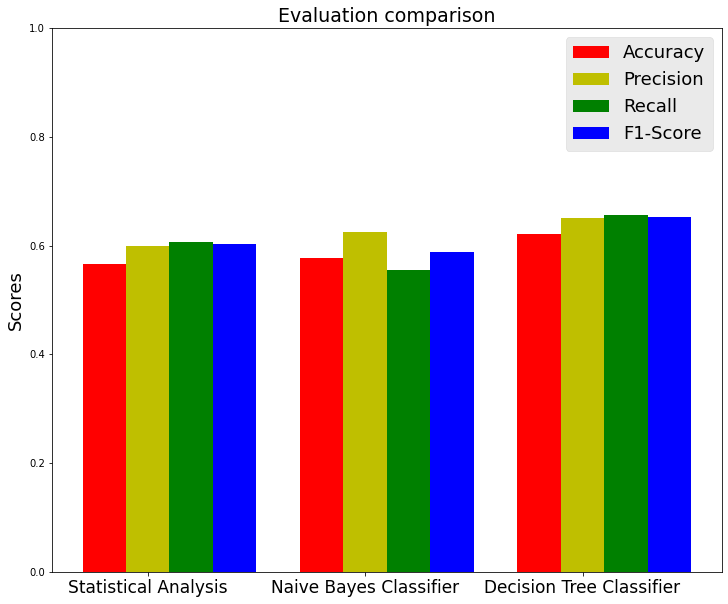

In [91]:
# Plotting the chart. 
# The Performance comparison of models.
 
N = 3
ind = np.arange(N) 
width = 0.2

plt.figure(figsize=(12,10))
  
xvals = accuracy_list
bar1 = plt.bar(ind, xvals, width, color = 'r')
  
yvals = precision_list
bar2 = plt.bar(ind+width, yvals, width, color='y')

zvals = recall_list
bar3 = plt.bar(ind+width*2, zvals, width, color = 'g')

avals = f1_list
bar4 = plt.bar(ind+width*3, avals, width, color = 'b')
  
plt.style.use('ggplot')
plt.ylabel('Scores',fontsize=18)
plt.ylim(0, 1)
plt.title("Evaluation comparison",fontsize=19)

plt.xticks(ind+width,['Statistical Analysis', 'Naive Bayes Classifier', 'Decision Tree Classifier'],fontsize=17)
plt.legend((bar1, bar2,bar3,bar4), ('Accuracy','Precision','Recall', 'F1-Score'),fontsize=12,prop={'size': 18})
plt.show()

# 6) Similarity Search of Price Patterns 

แสดงผลข้อมูลโดยเปรียบเทียบระหว่างรูปแบบราคาปัจจุบันกับรูปแบบราคาในอดีตที่คล้ายคลึงมากที่สุดในแต่ละรอบที่ทำการเทรนโมเดล

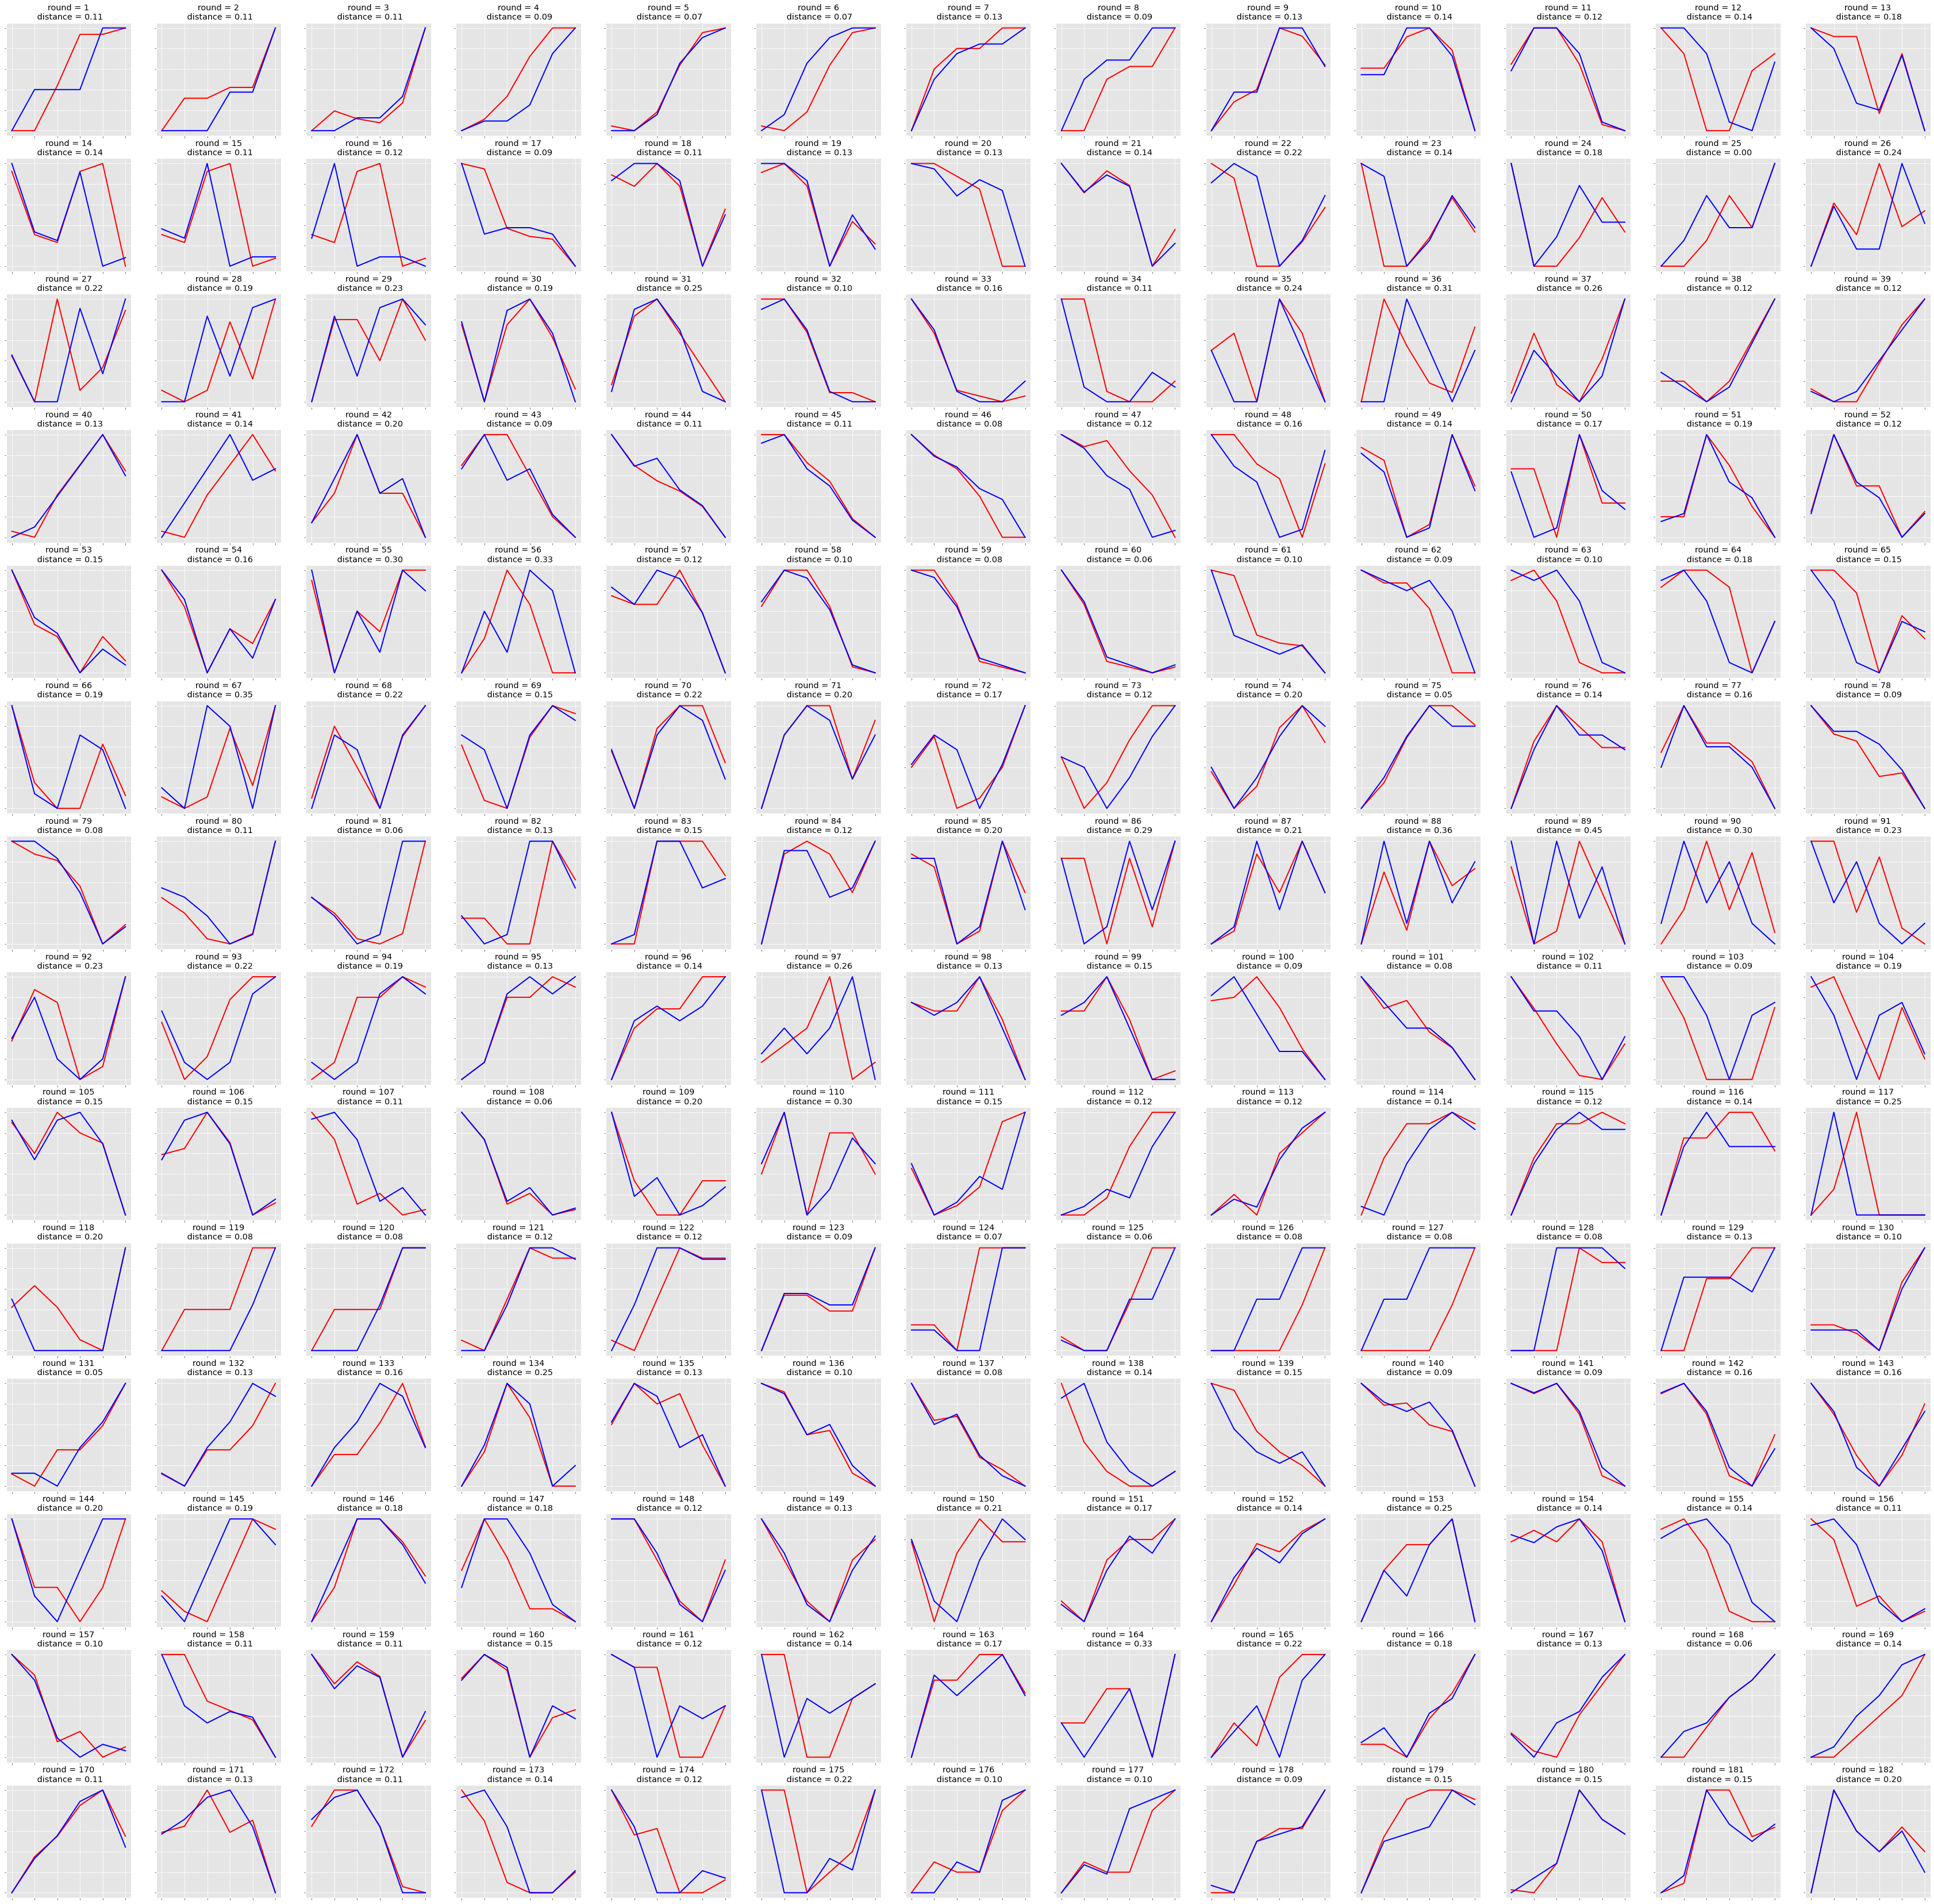

In [92]:
# Plotting graph show current pattern compared with most similar pattern in each training.  

round_train = 0
index = 0
columns = 13
rows = 14

fig, ax_array = plt.subplots(rows, columns, figsize=(60, 60))
for i,ax_row in enumerate(ax_array):
    for j,axes in enumerate(ax_row):
        axes.plot(most_similar_pattern_list_sub_1[index],c='r',linewidth ='2',label='Most similar pattern')
        axes.plot(current_pattern_list_1[index],c='b',linewidth ='2',label='Current pattern')
        round_train += 1
        axes.set_title('round = {}\n distance = {:.2f}'.format(round_train,most_similar_pattern_list_distance_1[index]))
        axes.set_yticklabels([])
        axes.set_xticklabels([])
        index += 1
plt.show()